In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.utils import img_to_array
from tqdm import tqdm
import numpy as np 
import pandas as pd 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Input, LeakyReLU, BatchNormalization, UpSampling2D, MaxPooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import tempfile

In [22]:
# import zipfile
# # from google.colab import drive


# zip_ref = zipfile.ZipFile("archive.zip", 'r')
# zip_ref.extractall("")
# zip_ref.close()


In [23]:
SIZE = 160
color_img = []
path = 'landscape Images/color'
files = os.listdir(path)
for i in tqdm(files):    
    img = cv2.imread(path + '/'+i,1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    color_img.append(img_to_array(img))


gray_img = []
path = 'landscape Images/gray'
files = os.listdir(path)
for i in tqdm(files):

    img = cv2.imread(path + '/'+i,1)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))

from sklearn.utils import resample
gray_img, color_img = resample(gray_img, color_img)


100%|██████████| 7129/7129 [00:02<00:00, 2377.49it/s]


In [24]:
cv2.__version__

'4.7.0'

In [1]:
# # Data Augmentation

# batch_size = 32

# def augment_func(image,label):
#   # Add 6 pixels of padding
#   image = tf.image.resize_with_crop_or_pad(image, height + 6, width + 6)
#    # Random crop back to the original size
#   image = tf.image.random_crop(image, size=[height, width, 3])
#   image = tf.clip_by_value(image, 0, 255)
#   image = tf.image.random_flip_left_right(image)
#   image = tf.image.random_hue(image, 0.2)
#   image = tf.image.random_contrast(image, 0.5, 2)
#   image = tf.image.random_saturation(image, 0, 2)
#   return image, label

# train_ds = train_ds.cache().map(augment_func).shuffle(100).batch(batch_size).prefetch(buffer_size=10)
# test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

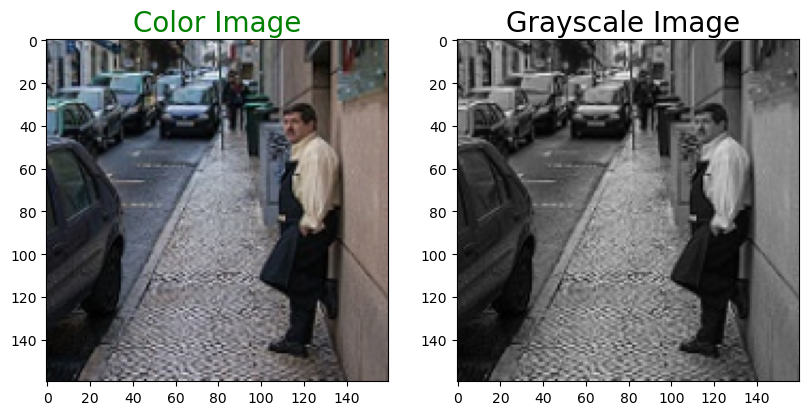

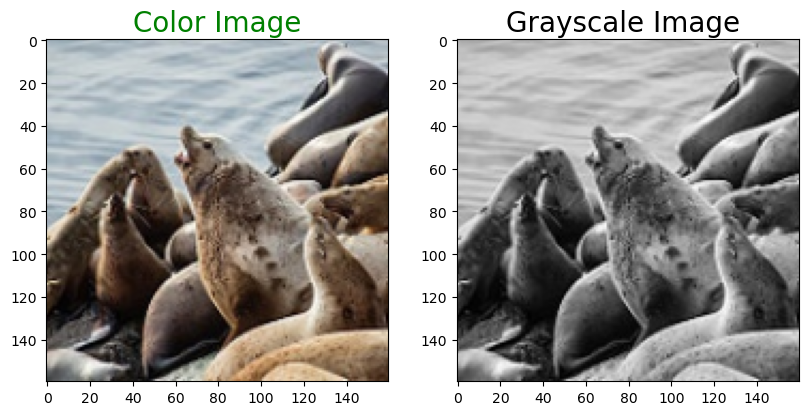

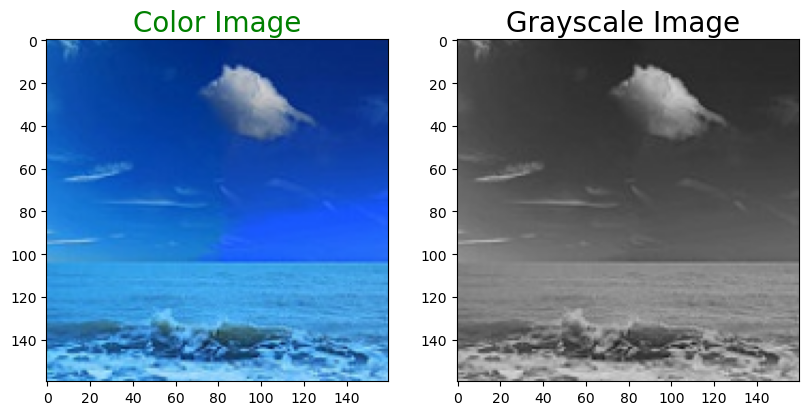

In [ ]:
for i in range(45,48):
    color = color_img[i]
    grayscale= gray_img[i]
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

In [ ]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (1629, 160, 160, 3)


In [15]:
import keras
from keras import layers
def encoder(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample
def decoder(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


In [16]:
def model():
    # downsampling
    
    inputs = layers.Input(shape= [160,160,3])
    d1 = encoder(128,(3,3),False)(inputs)
    d2 = encoder(128,(3,3),False)(d1)
    d3 = encoder(256,(3,3),True)(d2)
    d4 = encoder(512,(3,3),True)(d3)
    d5 = encoder(512,(3,3),True)(d4)

    #upsampling

    u1 = decoder(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = decoder(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = decoder(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = decoder(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = decoder(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = model()
model.summary()

Metal device set to: Apple M2 Pro
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192 

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, verbose=1)
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001), loss = 'huber',
              metrics = ['accuracy'])

history = model.fit(train_g, train_c,epochs = 100,batch_size = 8,verbose = 1, callbacks=[callback])
model.save('initial_model')
model.save_weights('model_weights.h5')

# _, pretrained_weights = tempfile.mkstemp('.tf')
#
# model.save_weights(pretrained_weights)



Epoch 1/100
688/688 [==============================] - 50s 72ms/step - loss: 0.0038 - accuracy: 0.4633
Epoch 2/100
688/688 [==============================] - 49s 71ms/step - loss: 0.0035 - accuracy: 0.4722
Epoch 3/100
688/688 [==============================] - 49s 71ms/step - loss: 0.0032 - accuracy: 0.4805
Epoch 4/100
688/688 [==============================] - 49s 71ms/step - loss: 0.0030 - accuracy: 0.4908
Epoch 5/100
688/688 [==============================] - 49s 72ms/step - loss: 0.0028 - accuracy: 0.5070
Epoch 6/100
688/688 [==============================] - 49s 71ms/step - loss: 0.0026 - accuracy: 0.5247
Epoch 7/100
688/688 [==============================] - 49s 71ms/step - loss: 0.0024 - accuracy: 0.5405
Epoch 8/100
688/688 [==============================] - 49s 71ms/step - loss: 0.0022 - accuracy: 0.5580
Epoch 9/100
688/688 [==============================] - 49s 71ms/step - loss: 0.0021 - accuracy: 0.5683
Epoch 10/100
688/688 [==============================] - 49s 71ms/step - l

INFO:tensorflow:Assets written to: initial_model/assets


INFO:tensorflow:Assets written to: initial_model/assets


In [20]:
model = model()
model.load_weights('model_weights.h5')

ValueError: The first argument to `Layer.call` must always be passed.

In [18]:
model.evaluate(test_gray_image,test_color_image)

NameError: name 'test_gray_image' is not defined

1/1 [==============================] - 0s 11ms/step


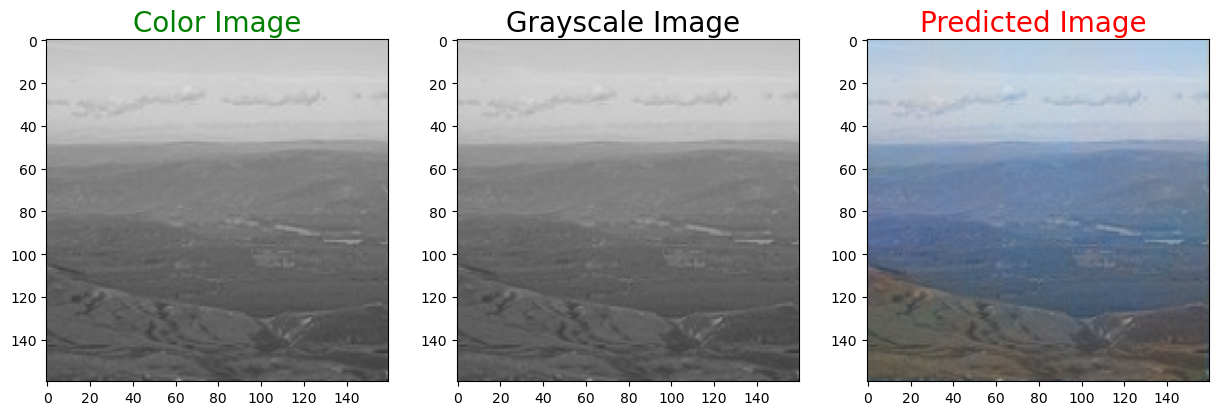

In [25]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

# for i in range(50,58):
#     predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
#     plot_images(test_color_image[i],test_gray_image[i],predicted)

img_g = cv2.imread("img2_g.jpg")
#resizing image
# img_g = img_g.resize(img_g, (SIZE, SIZE))
img_g = img.astype('float32')
img_c = cv2.imread("img2_c.jpg")
# img_c = cv2.resize(img_c, (SIZE, SIZE))
img_c = img.astype('float32')
predicted = np.clip(model.predict(img_g.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
plot_images(img_c, img_g,predicted)

In [ ]:
# model.load_weights(pretrained_weights)
# Convert current model to tflite
# Size before conversion: 116.2 MB
# converter = tf.lite.TFLiteConverter.from_saved_model("./initial_model")
# tflite_model = converter.convert()
# 38.4 MB after conversion

In [ ]:
# with open("tflite_model.tflite", "wb") as f:
#     f.write(tflite_model)

In [27]:
from tflite_model_maker.config import QuantizationConfig
config = QuantizationConfig.for_float16()
model.export(export_dir='.', tflite_filename='model_q.tflite', quantization_config=config)

ModuleNotFoundError: No module named 'tflite_model_maker'

## Processing any input image for input towards the model

In [29]:
# Binary Quantization
# model_q2 = model
# for layer in model_q2.layers:
#     weights = layer.get_weights()
#     if len(weights) > 0:
#         weights[0][weights[0] <= 0] = -1
#         weights[0][weights[0] > 0] = 1
#         layer.set_weights(weights)
#
# y_pred = model_q2.predict(train_c)
# y_pred = (y_pred > 0.5)
#
# model_q2.save('binary_quaantized_model')

model.evaluate(test_gray_image,test_color_image)

51/51 [==============================] - 7s 116ms/step - loss: 0.0015 - accuracy: 0.6757


[0.0015245083486661315, 0.6756645441055298]

In [ ]:
model_new = keras.models.load_model('initial_model')
model_new.load_weights('model_weights.h5')
img_g = cv2.imread("img2_g.jpg")
#resizing image
img_g = cv2.resize(img_g, (SIZE, SIZE))
# img_g = img.astype('float32') / 255.0
img_c = cv2.imread("img2_c.jpg")
#resizing image
img_c = cv2.resize(img_c, (SIZE, SIZE))
# img_c = img.astype('float32') / 255.0
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

predicted = np.clip(model_new.predict(img_g.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
plot_images(img_c, img_g,predicted)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]
output_index = interpreter.get_output_details()[0]["index"]
input_index

#
# interpreter.set_tensor(input_index, img)
# interpreter.invoke()
# predictions = interpreter.get_tensor(output_index)